In [4]:
# %load data_utils.py
"""
Utilities to query the dataset
"""
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
import itertools



def load_dataset(pkl_file_name):
    # Load a saved dataset into memory
    with open(pkl_file_name,'rb') as f:
        my_dataset = pickle.load(f)
    return(my_dataset)
    
def get_joint_pairs():
    joint_pairs = [[0, 1], [1, 3], [0, 2], [2, 4],
                   [5, 6], [5, 7], [7, 9], [6, 8], [8, 10],
                   [5, 11], [6, 12], [11, 12],
                   [11, 13], [12, 14], [13, 15], [14, 16]] 
    return(joint_pairs)    
    
def draw_skeleton(W,H,coords):
    img = np.zeros((W,H,3), np.uint8)
    joint_pairs = [[0, 1], [1, 3], [0, 2], [2, 4],
                   [5, 6], [5, 7], [7, 9], [6, 8], [8, 10],
                   [5, 11], [6, 12], [11, 12],
                   [11, 13], [12, 14], [13, 15], [14, 16]] 
    colormap_index = np.linspace(0, 1, len(joint_pairs))
    pts = coords
    for cm_ind, jp in zip(colormap_index, joint_pairs):
        cm_color = tuple([int(x * 255) for x in plt.cm.cool(cm_ind)[:3]]) 
        pt1 = (int(pts[jp, 0][0]), int(pts[jp, 1][0]))
        pt2 = (int(pts[jp, 0][1]), int(pts[jp, 1][1]))
        cv2.line(img, pt1, pt2, cm_color, 3)
    return(img)
    
def get_skeleton_frame(gymn_dataset,clip_ID,frame_number):
    coords = gymn_dataset["Skeletons"][clip_ID][frame_number]
    img = draw_skeleton(800,600,coords)
    return(img)
    
def show_skeleton_movie(gymn_dataset,clip_ID):
    #not working
    sk_list = gymn_dataset["Skeletons"][clip_ID]
    fig = plt.figure()
    ims = []
    for sk_frame in sk_list:
        if type(sk_frame)==np.ndarray:
            skeleton_img = draw_skeleton(800,600,sk_frame)
            cv2.imshow('La',skeleton_img)
            im = plt.imshow(skeleton_img,animated=True)
            ims.append([im])
    ani = animation.ArtistAnimation(fig,ims,interval=500,blit=True,repeat_delay=1000)            
    plt.show()
    return(ani)
    
def get_list_720(keypoint_list,joint_list):
    prod_list = list(itertools.product(keypoint_list,joint_list))
    curated_list = []
    for key_point,joint in prod_list:
        sw = key_point == joint[0] or key_point == joint[1]
        if not sw :
            curated_list.append([key_point,joint])
    return(curated_list)

def scale_linear_bycolumn(rawpoints, high=255.0, low=0.0):
    mins = np.min(rawpoints, axis=0)
    maxs = np.max(rawpoints, axis=0)
    rng = maxs - mins
    return high - (((high - low) * (maxs - rawpoints)) / rng)    
    
def length_square(p1,p2):
    # returns square of distance b/w two points 
    x1,y1 = p1
    x2,y2 = p2
    dy = y2-y1  
    dx = x2-x1  
    return dx*dx + dy*dy

def get_angles(p1,p2,p3):
    # Square of lengths be a2, b2, c2 
    a2 = length_square(p2,p3)
    b2 = length_square(p1,p3)
    c2 = length_square(p1,p2)
    # length of sides be a, b, c 
    a = math.sqrt(a2)
    b = math.sqrt(b2)    
    c = math.sqrt(c2)
    # From Cosine law 
    alpha = math.acos((b2 + c2 - a2)/(2*b*c))
    betta = math.acos((a2 + c2 - b2)/(2*a*c))
    gamma = math.acos((a2 + b2 - c2)/(2*a*b))
    return alpha*180/math.pi, betta*180/math.pi, gamma*180/math.pi
    
def calc_features_720(keypoint,joint_a,joint_b):
    # Calculates the distance("Magnitude") between two points
    # and relative position descriptors
    x1,y1 = joint_a
    x2,y2 = joint_b
    x3,y3 = keypoint
    dy = y2-y1  
    dx = x2-x1  
    distance_to_joint = 0
    if abs(dx)>0:
        m = dy/dx
        # generates an line equation of the form ax + by + c = 0 (p1,p2)
        a = m             
        b = -1
        c =  y1 - (m*x1)  
        nm = abs((a*x3)+(b*y3)+c)
        dm = math.sqrt(a**2+b**2)
        if dm>0:
            distance_to_joint = abs(nm/dm)
    if distance_to_joint>5:
        t,b,g = get_angles(keypoint,joint_a,joint_b)
        feat_list = [distance_to_joint, t, b]
    else:
        feat_list = [0, 0, 0]
    return feat_list
    
def calc_features_136(p1,p2):
    # Calculates the distance("Magnitude") between two points
    # and relative position descriptors
    x1,y1 = p1
    x2,y2 = p2
    dy = y2-y1  # Relative Position Descriptor (x)
    dx = x2-x1  # Relative Poisition Descriptor (y)
    magnitude = math.sqrt(dx*dx + dy*dy)
    feat_list = [dx, dy, magnitude]
    return feat_list    
   
            
class GymnDataSet:
    '''
    Class designed to read skeleton dataset from a picklefile
    and transform it to RGB images
    '''
    def __init__(self,pickle_file_name,load_now=True):
        self.pkl_file_name = pickle_file_name
        self.threshold = 0.2
        self.keypoints = 17   # 17 Keypoints COCO
        self.scene_size = 15  # 15 frames per scene (4.5s)
        self.scene_skip_frames = 3  # 3 frames = 1s
        self.joints = [[0, 1], [1, 3], [0, 2], [2, 4],
                       [5, 6], [5, 7], [7, 9], [6, 8], [8, 10],
                       [5, 11], [6, 12], [11, 12],
                       [11, 13], [12, 14], [13, 15], [14, 16]] 
        if load_now:
            self.loadData()
    
    def loadData(self):
        with open(self.pkl_file_name,'rb') as f:
            data = pickle.load(f)  
            clip_list = data["ClipList"]
            val_idx = clip_list['CroppedPerson'] /clip_list['NumberOfFrames'] < self.threshold
            self.ClipList = clip_list[val_idx]
            skeletons = {}
            for idx, clip in self.ClipList.iterrows():
                clip_id = clip['PoseClipId']
                sk_list = data['Skeletons'][clip_id]
                cp = data['CroppedPerson'][clip_id]
                ep = data['ExtraPerson'][clip_id]
                frames_with_issues = np.logical_or(cp,ep) 
                vf = []
                frm_idx = 0                
                frames_with_issues = np.logical_or(cp,ep)
                for frame in frames_with_issues:
                    if not frame:
                        vf.append(sk_list[frm_idx])
                    frm_idx += 1  
                skeletons[clip_id] = vf
            self.Skeletons = skeletons
            print('Data loaded and CLEANED!!.')
            
    def SetThreshold(self,new_threshold):
        self.threshold = new_threshold
    
    
    def getClipHeader(self,clip_id):
        c_l = self.ClipList
        idx_clip = c_l['PoseClipId'] == clip_id
        return(c_l[idx_clip])
        
    def getSkeletons(self,clip_id):
        clp_hdr = self.getClipHeader(clip_id)
        if len(clp_hdr)>0:
            return(self.Skeletons[clip_id])
        else:
            print('Clip not found or invalid!')
            return(None)
            
    def GetSkeletonFeatures(self,clip_id,sk_id):
        joints = self.joints
        sk_list = self.getSkeletons(clip_id)
        list_136 = list(itertools.combinations(list(range(self.keypoints)),2))
        list_240 = get_list_720(list(range(self.keypoints)),joints)
        feat_136 = []
        feat_240 = []
        if not sk_list is None:
            if sk_id > len(sk_list)-1:
                print('Error, beyond skeleton range ')
            else:
                skeleton = sk_list[sk_id]
                for kp_a,kp_b in list_136:
                    p1 = skeleton[kp_a]
                    p2 = skeleton[kp_b]
                    sk_feat = calc_features_136(p1,p2)
                    feat_136.append(sk_feat)
                for keypoint,joint in list_240:
                    kp = skeleton[keypoint]
                    joint_a = skeleton[joint[0]]
                    joint_b = skeleton[joint[1]]
                    #print(keypoint," KP=",kp," ",joint,"  A=",joint_a,"  B=",joint_b)
                    sk_feat = calc_features_720(kp,joint_a,joint_b)
                    feat_240.append(sk_feat)
        return feat_136,feat_240
    
    def GetFramePic(self,clip_id,sk_id):
        p1,p2 = self.GetSkeletonFeatures(clip_id,sk_id)
        p1n = scale_linear_bycolumn(p1)
        p2n = scale_linear_bycolumn(p2)
        img = np.concatenate((p1n.flatten(),p2n.flatten()))
        return img.reshape(47,8,3).astype(int)
    
    def GetScene(self,clip_id,sc_number=0):
        sk_list = self.getSkeletons(clip_id)
        first_frame = sc_number * self.scene_skip_frames
        if (first_frame+self.scene_size>len(sk_list)):
            print('Not enough frames')
            return None
        else:
            for i in range(self.scene_size):
                a_frame = self.GetFramePic(clip_id,first_frame+i)
                if i==0:
                    final_img = a_frame
                else:
                    final_img = np.append(final_img,a_frame,axis=1)
        return final_img
                
                
        
        
            

In [5]:
mydata = GymnDataSet('GymnData.pickle')

Data loaded and CLEANED!!.


In [6]:
clip_list = mydata.ClipList

In [7]:
clip_list.head()

,PoseClipId,FileName,VideoSourceId,ExerciseType,ClipNumber,SampleType,CroppedPerson,ExtraPerson,NumberOfFrames
0,62328429,011_SeatedInAndOuts_002_BAD.mp4,011,SeatedInAndOuts,002,BAD,0,0,41
1,25622089,010_RussianTwist_002_GOOD.mp4,010,RussianTwist,002,GOOD,0,0,30
3,45848267,001_BulgarianSplitSquat_002_GOOD.mp4,001,BulgarianSplitSquat,002,GOOD,0,0,50
5,96971732,007_PlankKneeToElbows_001_BAD.mp4,007,PlankKneeToElbows,001,BAD,3,0,24
6,2092888,006_MountainClimber_002_BAD.mp4,006,MountainClimber,002,BAD,0,0,27


In [8]:
img1 = mydata.GetScene(62328429,0)

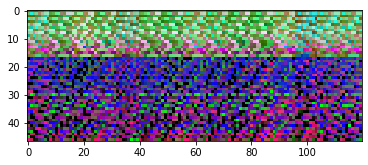

In [9]:
imgplot = plt.imshow(img1)

In [10]:
img1 = mydata.GetScene(62328429,3)

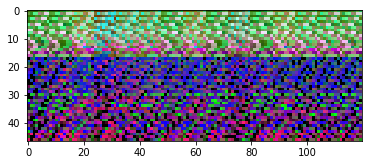

In [11]:
imgplot = plt.imshow(img1)